In [1]:
import numpy as np
import pandas as pd
#import matplotlib as plt
import nltk
import json
import sklearn

In [2]:
import pickle
from fs_s3fs import S3FS

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
#from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation

random_state = 1234

In [4]:
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# Defining needed functions

In [5]:
def build_feature_matrix(documents,
                         feature_type='frequency',
                         ngram_range=(1, 1),
                         min_df=0.0,
                         max_df=1.0):
    feature_type = feature_type.lower().strip()

    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True,
                                     min_df=min_df,
                                     max_df=max_df,
                                     ngram_range=ngram_range)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False,
                                     min_df=min_df,
                                     max_df=max_df,
                                     ngram_range=ngram_range)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df,
                                     max_df=max_df,
                                     ngram_range=ngram_range)
    elif feature_type == 'tfidf_stopwords':
        vectorizer = TfidfVectorizer(min_df=min_df,
                                     max_df=max_df,
                                     ngram_range=ngram_range,
                                     #stop_words=stopwords.words('english'))
                                     stop_words="english")
    else:
        raise Exception(
            "Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf', 'tfidf_stopwords'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)

    return vectorizer, feature_matrix

In [35]:
def get_bucket(bucket_name='watson-main-bucket-dev'):
    s3_conf = {
        'bucket_name': bucket_name,
        'aws_access_key_id': 'xxxxxxxxxxxxxxxx',
        'aws_secret_access_key': 'xxxxxxxxxxxxxxx',
        'endpoint_url': 'xxxxxxxxxxxxxxx',
        'region': 'xxxxxxxxxxxx',
    }
    return S3FS(**s3_conf)

In [8]:
def get_tokens(text):
    tokens = word_tokenize(text)
    return tokens

In [9]:
def get_tokens_lower_case(text):
    tokens = word_tokenize(text.lower())
    return tokens

In [6]:
def plot_elbow(sentences, feature_type=None, max_clusters=10, ngram_range=(1,1), random_state = 1234): 
    
    if feature_type:
        vectorizer, feature_matrix = build_feature_matrix(sentences, 
                                                          feature_type='tfidf', 
                                                          ngram_range=ngram_range,
                                                          min_df=0.0,
                                                          max_df=1.0
                                                         )
    elbow = dict()

    feature_matrix = sentences
    
    for n_cluster in range(2,max_clusters): 

        kmeans = MiniBatchKMeans(n_clusters=n_cluster, compute_labels=True, random_state=1234).fit(feature_matrix)
        
        print('cluster number {0}'.format(n_cluster))

        elbow[n_cluster] = kmeans.inertia_
        
        print('inertia {0}'.format(kmeans.inertia_))
        
    
    figs, axes = plt.subplots(figsize=(8,6))

    x = np.array(list(elbow.keys()))
    y = np.array(list(elbow.values()))


    axes.plot(x, y,'-o')
#     axes.text(5, 19200, 'S = Sum of squared distances \n of samples to their closest cluster center.', fontsize=15)

    axes.set_xlim(0,max_clusters)
    axes.set_ylabel('S', fontsize=15)
    axes.set_xlabel('n clusters',fontsize=15)

    xint = range(2,max_clusters)
    matplotlib.pyplot.xticks(xint)
    plt.grid(axis='both')

    # =================
    # Plot derivative 
    # =================

    dy = np.zeros(y.shape,np.float)
    dy[0:-1] = np.diff(y)/np.diff(x)
    dy[-1] = (y[-1] - y[-2])/(x[-1] - x[-2])

    ax2 = axes.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    # ax2.set_ylabel(r'$\frac{dS}{dn_c}$ - Derivative', color=color, fontsize=15)  # we already handled the x-label with ax1
    ax2.set_ylabel('Derivative', color=color, fontsize=15)  # we already handled the x-label with ax1
    ax2.plot(x, dy, '-o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

In [7]:
def plot_silhouette_clusters(sentences, max_clusters=10, random_state = 1234): 
    
    elbow = dict()

    feature_matrix = sentences
    
    for n_cluster in range(2,max_clusters): 

        kmeans = KMeans(n_clusters=n_cluster, random_state=random_state).fit(feature_matrix)
        
        print('cluster number {0}'.format(n_cluster))

        elbow[n_cluster] = silhouette_score(feature_matrix, labels=kmeans.labels_)
        
        print('silhouette score {0}'.format(elbow[n_cluster]))
        
    
    figs, axes = plt.subplots(figsize=(12,6))

    x = np.array(list(elbow.keys()))
    y = np.array(list(elbow.values()))


    axes.plot(x, y,'-o')

    axes.set_xlim(0,max_clusters)
    axes.set_ylabel('Silhouette', fontsize=15)
    axes.set_xlabel('n clusters',fontsize=15)

    xint = range(2,max_clusters)
    matplotlib.pyplot.xticks(xint)
    plt.grid(axis='both')

### Using S3FS to connect to COS

In [36]:
bucket = get_bucket()

In [37]:
type(bucket)

fs_s3fs._s3fs.S3FS

In [7]:
bucket.exists('xxxxxxxxxxxxxxxx')

False

# Using TEST data

## Creating the corpus

In [13]:
with open('shalist_silvia.pkl','rb') as f:
    sha_list = pickle.load(f)    

In [14]:
len(sha_list)

72

In [13]:
corpus = list()

for contract in sha_list:
    if bucket.exists(contract+'_result'):
        with bucket.open(contract+'_result','r') as f:
            watson = json.load(f)
            content = ' '.join([it['text'] for it in watson['elements']])
            corpus.append(content)

In [14]:
len(corpus)

72

In [15]:
# saving corpus created from all 72 documents
pickle.dump(corpus,open("corpus.pkl","wb"))

In [38]:
# loading corpus if already created
with open('corpus.pkl','rb') as f:
    corpus = pickle.load(f)    

In [39]:
len(corpus)

72

Test: getting the content for a single JSON

In [42]:
#content = ' '.join([it['text'] for it in corpus[0]['elements']])
content = corpus[0]

**Splitting up the corpus between training and testing**

In [17]:
corpus_train, corpus_test = train_test_split(corpus, test_size=0.2)

In [18]:
len(corpus_train)

57

In [19]:
len(corpus_test)

15

## Doc2Vec

In [53]:
sentences = nltk.sent_tokenize(content)

In [64]:
data = ["I love machine learning. Its awesome.",
        "I love coding in python",
        "I love building chatbots",
        "they chat amagingly well"]

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(word_tokenize(content))]

In [69]:
len(tagged_data)

4214

In [66]:
max_epochs = 100
vec_size = 300
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v_word.model")
print("Model Saved")

/usr/local/lib64/python3.6/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [67]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v_word.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize(content.lower())
v1_word = model.infer_vector(test_data)
print("V1_infer", v1_word)

# to find most similar doc using tags
#similar_doc = model.docvecs.most_similar('1')
#print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
#print(model.docvecs['1'])

V1_infer [ 5.78236319e-02  1.71092510e-01 -5.48305809e-01 -1.46936715e-01
  5.46727926e-02 -3.74648161e-02 -2.00825602e-01 -6.27553403e-01
 -6.91097006e-02  2.68422425e-01 -7.60015398e-02  1.10021077e-01
 -3.43658067e-02  8.68047178e-02  2.04500332e-01 -6.63839094e-03
  4.07664806e-01  1.83923617e-01  1.05116986e-01 -4.15453501e-02
  1.08120359e-01  1.15765832e-01  1.09680407e-01  4.27759513e-02
 -1.15873910e-01 -4.69475389e-02 -7.11567178e-02  1.94420382e-01
  4.67568606e-01 -1.69799909e-01 -2.35168822e-02 -2.88092703e-01
  5.73572293e-02 -3.54737043e-02 -7.54002184e-02 -4.70217049e-01
 -1.72119647e-01 -3.13660782e-03 -1.09373458e-01 -2.83146590e-01
  1.63195643e-03  4.61432114e-02  2.88618784e-02  2.41461053e-01
 -1.52211323e-01 -1.82414129e-02  1.03065580e-01  6.76431954e-02
 -6.98398054e-03  3.73966782e-03  5.91396540e-02 -2.05944568e-01
 -1.04412377e-01 -3.07801753e-01 -9.63637512e-03  1.23901717e-01
 -4.58761193e-02 -4.28342015e-01  6.31967962e-01  3.61387908e-01
 -4.98795807e-01

In [68]:
print("V1_infer", v1)

V1_infer [-1.90983444e-01  9.28932950e-02 -1.24147810e-01  2.55694598e-01
  3.10085773e-01  2.87562966e-01  7.58560449e-02 -1.20759696e-01
 -6.57311007e-02 -6.64285123e-02  7.06042768e-03  1.12228788e-01
 -3.39086726e-02  1.67437151e-01 -1.24864057e-01 -4.02576506e-01
 -1.41316578e-01  6.84262440e-02 -1.00176660e-02  2.47795895e-01
 -2.31487557e-01 -8.80443454e-02 -8.61545186e-03  6.43084291e-04
 -7.79026970e-02 -6.64854273e-02 -2.66796619e-01  2.67901063e-01
  7.87079707e-02  6.23384193e-02  5.73635809e-02  9.00838003e-02
  1.78767756e-01 -5.52528091e-02 -4.06106710e-02  1.75005272e-01
  1.54902428e-01  6.34847209e-02 -1.73542351e-01  2.21617937e-01
 -2.52931546e-02 -1.82856873e-01 -2.55996615e-01 -7.62168914e-02
  6.44731596e-02  4.10954803e-02  1.97837483e-02  1.73550084e-01
 -1.64473087e-01 -3.15668315e-01 -3.37055624e-01  1.69503130e-02
 -1.32387236e-01  6.37513697e-02 -1.67294562e-01 -3.27356113e-03
  1.94961667e-01  3.11620414e-01  5.27023822e-02 -2.20033288e-01
  1.40786663e-01

## Using feature extraction and KMeans

**Feature extraction**

In [20]:
vectorizer,matrix = build_feature_matrix(corpus,
                         feature_type='tfidf',
                         ngram_range=(1, 1),
                         min_df=0.0,
                         max_df=1.0)

In [21]:
vectorizer.transform(['service']).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [22]:
matrix

<72x9692 sparse matrix of type '<class 'numpy.float64'>'
	with 130124 stored elements in Compressed Sparse Row format>

**Elbow plot to get the most representative number of clusters**

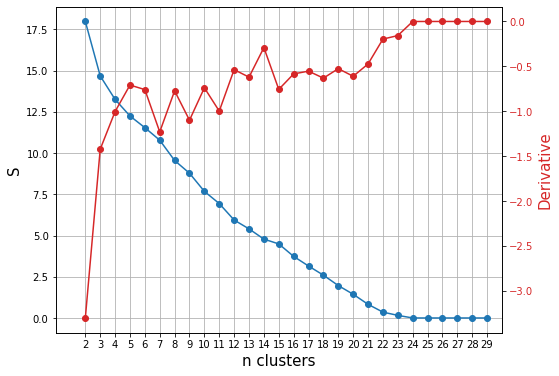

In [23]:
plot_elbow(matrix, max_clusters=30, ngram_range=(1,1), random_state = 1234)

**Creating the training model**

In [24]:
# for reproducibility
random_state = 1234

cls = KMeans(n_clusters=24, random_state=random_state)
cls.fit(matrix)

KMeans(n_clusters=24, random_state=1234)

In [25]:
cls.predict(matrix)

array([10, 10,  5,  9, 16, 10, 22,  4,  4,  4, 18,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        4, 20, 15, 17, 13,  4,  0,  4,  0,  4,  0,  4,  4,  4,  1,  1,  1,
        1,  1,  1, 21, 19,  4,  4,  4,  1,  0,  4,  4, 12,  8,  2, 14,  6,
       23,  7, 11,  3], dtype=int32)

In [27]:
silhouette_score(matrix, labels=cls.labels_)

0.7133923759015731

In [28]:
cls.inertia_

0.0008165731188052305

**Reducing the dimension of features for visualization**

In [29]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(matrix.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
print(cls.labels_)

[10 10  5  9 16 10 22  4  4  4 18  4  4  4  4  4  4  4  4  4  4  4  4  4
  0  0  0  0  0  1  1  1  1  1  4 20 15 17 13  4  0  4  0  4  0  4  4  4
  1  1  1  1  1  1 21 19  4  4  4  1  0  4  4 12  8  2 14  6 23  7 11  3]


[10 10  5  9 16 10 22  4  4  4 18  4  4  4  4  4  4  4  4  4  4  4  4  4
  0  0  0  0  0  1  1  1  1  1  4 20 15 17 13  4  0  4  0  4  0  4  4  4
  1  1  1  1  1  1 21 19  4  4  4  1  0  4  4 12  8  2 14  6 23  7 11  3]


72

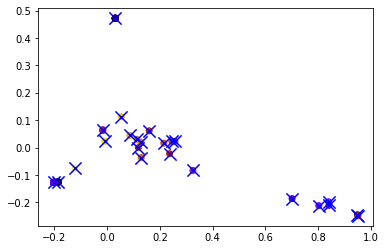

In [30]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(matrix), cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
print(cls.predict(matrix))
len(cls.predict(matrix))

## Removing stopwords during feature extraction

In [31]:
vectorizer_v2,matrix_v2 = build_feature_matrix(corpus,
                         feature_type='tfidf_stopwords',
                         ngram_range=(1, 1),
                         min_df=0.0,
                         max_df=1.0)

In [32]:
vectorizer_v2.transform(['service']).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [33]:
matrix_v2

<72x9442 sparse matrix of type '<class 'numpy.float64'>'
	with 120216 stored elements in Compressed Sparse Row format>

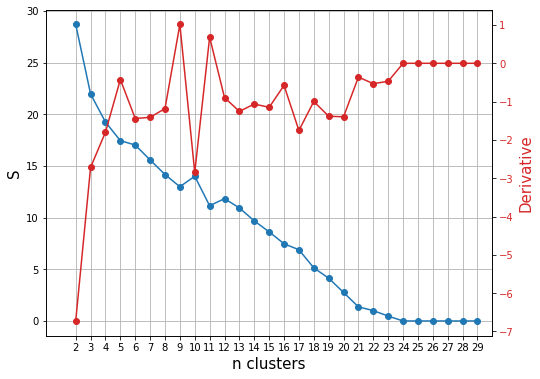

In [34]:
plot_elbow(matrix_v2, max_clusters=30, ngram_range=(1,1), random_state = 1234)

In [35]:
# for reproducibility
random_state = 1234

cls_v2 = KMeans(n_clusters=24, random_state=random_state)
cls_v2.fit(matrix_v2)

KMeans(n_clusters=24, random_state=1234)

In [36]:
cls_v2.predict(matrix_v2)

array([11, 11,  9, 12, 13, 11,  5,  3,  3,  3, 19,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        3,  4, 21, 20, 10,  3,  0,  3,  0,  3,  0,  3,  3,  3,  1,  1,  1,
        1,  1,  1, 18, 15,  3,  3,  3,  1,  0,  3,  3, 17, 14,  2, 22,  6,
       23,  7, 16,  8], dtype=int32)

In [38]:
silhouette_score(matrix_v2, labels=cls_v2.predict(matrix_v2))

0.7130415356031227

In [39]:
cls_v2.inertia_

0.0025901044235002724

In [40]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_v2 = pca.fit_transform(matrix_v2.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_v2 = pca.transform(cls_v2.cluster_centers_)

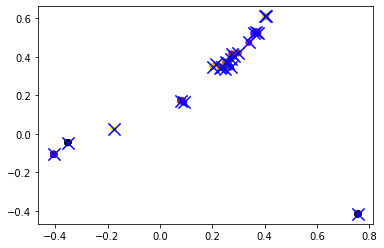

In [41]:
plt.scatter(reduced_features_v2[:,0], reduced_features_v2[:,1], c=cls_v2.predict(matrix_v2),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_v2[:, 0], reduced_cluster_centers_v2[:,1], marker='x', s=150, c='b')

## Changing n-gram to 1,2

In [43]:
vectorizer_v12,matrix_v12 = build_feature_matrix(corpus,
                         feature_type='tfidf',
                         ngram_range=(1, 2),
                         min_df=0.0,
                         max_df=1.0)

In [44]:
vectorizer_v12.transform(['service']).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [45]:
matrix_v12

<72x78645 sparse matrix of type '<class 'numpy.float64'>'
	with 667208 stored elements in Compressed Sparse Row format>

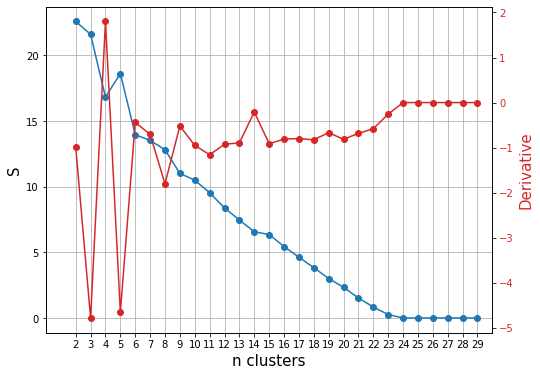

In [46]:
plot_elbow(matrix_v12, max_clusters=30, ngram_range=(1,2), random_state = 1234)

In [47]:
cls_v12 = KMeans(n_clusters=24, random_state=random_state)
cls_v12.fit(matrix_v12)

KMeans(n_clusters=24, random_state=1234)

In [48]:
cls_v12.predict(matrix_v12)

array([ 3,  3,  9,  5, 12,  3, 22,  4,  4,  4, 20,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        4, 19, 11, 17, 13,  4,  0,  4,  0,  4,  0,  4,  4,  4,  1,  1,  1,
        1,  1,  1, 15, 18,  4,  4,  4,  1,  0,  4,  4, 10, 14, 16,  2,  7,
       23,  6, 21,  8], dtype=int32)

In [50]:
silhouette_score(matrix_v12, labels=cls_v12.labels_)

0.709516834897349

In [51]:
cls_v12.inertia_

0.0022733725757916323

In [52]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_v12 = pca.fit_transform(matrix_v12.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_v12 = pca.transform(cls_v12.cluster_centers_)

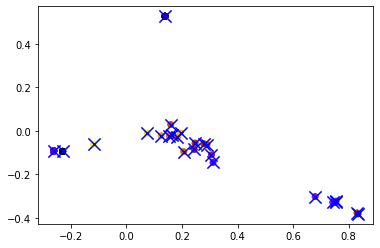

In [53]:
plt.scatter(reduced_features_v12[:,0], reduced_features_v12[:,1], c=cls_v12.predict(matrix_v12),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_v12[:, 0], reduced_cluster_centers_v12[:,1], marker='x', s=150, c='b')

## Changing n-gram to 2,2

In [54]:
vectorizer_v22,matrix_v22 = build_feature_matrix(corpus,
                         feature_type='tfidf',
                         ngram_range=(2, 2),
                         min_df=0.0,
                         max_df=1.0)

In [55]:
vectorizer_v22.transform(['service']).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [56]:
matrix_v22

<72x68953 sparse matrix of type '<class 'numpy.float64'>'
	with 537084 stored elements in Compressed Sparse Row format>

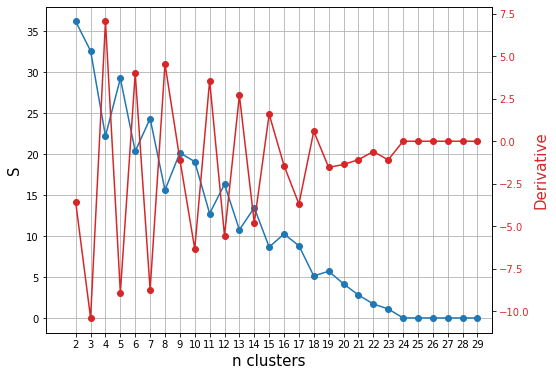

In [57]:
plot_elbow(matrix_v22, max_clusters=30, ngram_range=(2,2), random_state = 1234)

In [58]:
cls_v22 = KMeans(n_clusters=24, random_state=random_state)
cls_v22.fit(matrix_v22)

KMeans(n_clusters=24, random_state=1234)

In [59]:
cls_v22.predict(matrix_v22)

array([ 3,  3, 12, 13, 16,  3, 20,  1,  1,  1, 18,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  2,  2,  2,  2,  2,
        1,  5,  7, 19, 15,  1,  0,  1,  0,  1,  0,  1,  1,  1,  2,  2,  2,
        2,  2,  2, 10, 17,  1,  1,  1,  2,  0,  1,  1, 14,  4, 22,  8,  6,
       23,  9, 21, 11], dtype=int32)

In [61]:
silhouette_score(matrix_v22, labels=cls_v22.labels_)

0.7052688075609322

In [62]:
cls_v22.inertia_

0.01371654542321954

In [63]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_v22 = pca.fit_transform(matrix_v22.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_v22 = pca.transform(cls_v22.cluster_centers_)

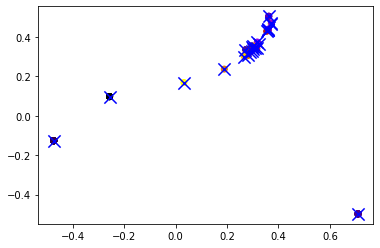

In [64]:
plt.scatter(reduced_features_v22[:,0], reduced_features_v22[:,1], c=cls_v22.predict(matrix_v22),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_v22[:, 0], reduced_cluster_centers_v22[:,1], marker='x', s=150, c='b')

## Affinity Propagation

In [92]:
vectorizer_af,matrix_af = build_feature_matrix(corpus_test,
                         feature_type='tfidf',
                         ngram_range=(1, 1),
                         min_df=0.0,
                         max_df=1.0)

In [93]:
vectorizer_af.transform(['service']).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [94]:
matrix_af

<15x4148 sparse matrix of type '<class 'numpy.float64'>'
	with 25324 stored elements in Compressed Sparse Row format>

In [98]:
af = AffinityPropagation(random_state=random_state)
af.fit(matrix_af)

AffinityPropagation(random_state=1234)

In [96]:
af.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 3])

In [100]:
af.predict(matrix_af.todense())

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 3])

In [101]:
af.cluster_centers_

<4x4148 sparse matrix of type '<class 'numpy.float64'>'
	with 4074 stored elements in Compressed Sparse Row format>

In [102]:
af.n_iter_

16

# Using Production data

## df_min = 0

In [8]:
# loading feature matrix
with open('feature_matrix_prod_tfidf_ngram_1_1_min_df_0_max_df_1.pkl','rb') as f:
    feature_matrix_min0 = pickle.load(f) 

In [9]:
print("n_samples: %d, n_features: %d" % feature_matrix_min0.shape)

n_samples: 741, n_features: 135682


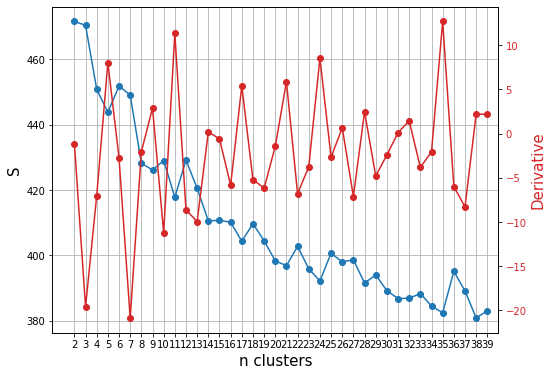

In [120]:
plot_elbow(feature_matrix_min0, max_clusters=40, ngram_range=(1,1), random_state = random_state)

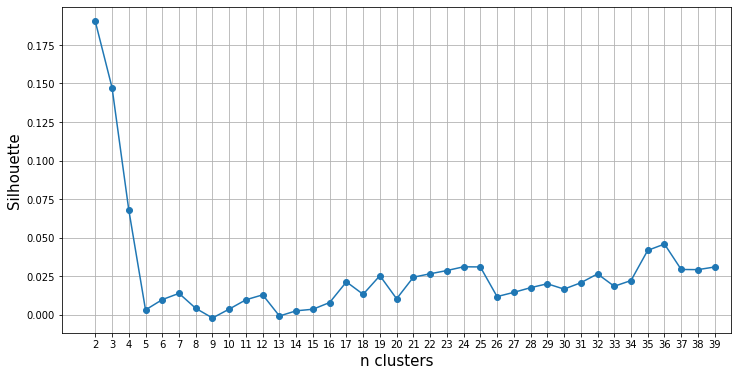

In [33]:
plot_silhouette_clusters(feature_matrix_min0, max_clusters=40, random_state = random_state)

In [34]:
cls_prod = KMeans(n_clusters=3, random_state=random_state)
cls_prod.fit(feature_matrix_min0)

KMeans(n_clusters=3, random_state=1234)

In [35]:
cls_prod.predict(feature_matrix_min0)

array([1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 2,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2,
       1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,

In [36]:
silhouette_score(feature_matrix_min0, labels=cls_prod.labels_)

0.14729782621923077

In [37]:
cls_prod.inertia_

448.97132728214666

In [38]:
cls_prod.n_iter_

12

In [39]:
cls_prod.cluster_centers_

array([[2.94760416e-02, 7.95592586e-03, 4.82167208e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.56715118e-03, 6.78109570e-03, 1.99494776e-04, ...,
        8.00590783e-06, 1.60118157e-05, 4.04297887e-05],
       [5.55486486e-03, 2.92073712e-03, 2.87399395e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [17]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_prod = pca.fit_transform(feature_matrix_min0.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_prod = pca.transform(cls_prod.cluster_centers_)

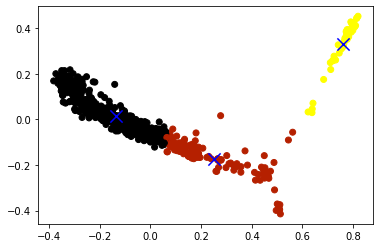

In [18]:
plt.scatter(reduced_features_prod[:,0], reduced_features_prod[:,1], c=cls_prod.predict(feature_matrix_min0),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_prod[:, 0], reduced_cluster_centers_prod[:,1], marker='x', s=150, c='b')

## df_min = 0.1

In [19]:
# loading feature matrix
with open('feature_matrix_prod_tfidf_ngram_1_1_min_df_0p1_max_df_1.pkl','rb') as f:
    feature_matrix_min01 = pickle.load(f) 

In [20]:
print("n_samples: %d, n_features: %d" % feature_matrix_min01.shape)

n_samples: 741, n_features: 2898


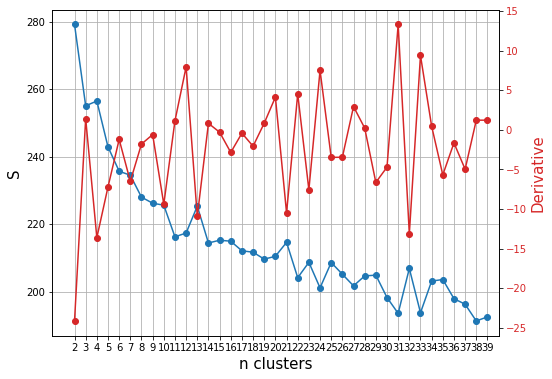

In [161]:
plot_elbow(feature_matrix_min01, max_clusters=40, ngram_range=(1,1), random_state = random_state)

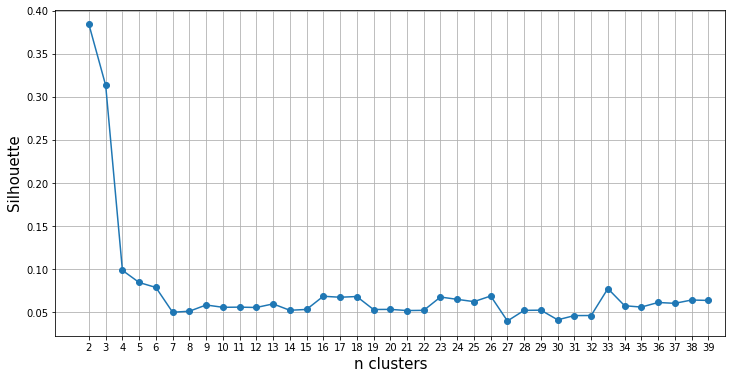

In [40]:
plot_silhouette_clusters(feature_matrix_min01, max_clusters=40, random_state = random_state)

In [41]:
cls_prod_min01 = KMeans(n_clusters=3, random_state=random_state)
cls_prod_min01.fit(feature_matrix_min01)

KMeans(n_clusters=3, random_state=1234)

In [42]:
cls_prod_min01.predict(feature_matrix_min01)

array([1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 0,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 2,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0,
       1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,

In [43]:
silhouette_score(feature_matrix_min01, labels=cls_prod_min01.labels_)

0.3134404295539484

In [44]:
cls_prod_min01.inertia_

253.76944966100086

In [45]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_prod_min01 = pca.fit_transform(feature_matrix_min01.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_prod_min01 = pca.transform(cls_prod_min01.cluster_centers_)

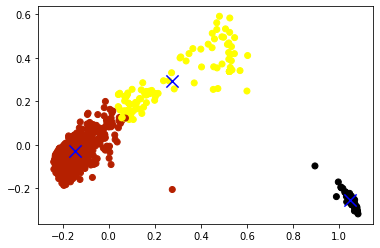

In [46]:
plt.scatter(reduced_features_prod_min01[:,0], reduced_features_prod_min01[:,1], c=cls_prod_min01.predict(feature_matrix_min01),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_prod_min01[:, 0], reduced_cluster_centers_prod_min01[:,1], marker='x', s=150, c='b')

## df_min = 0.01

In [47]:
# loading feature matrix
with open('feature_matrix_prod_tfidf_ngram_1_1_min_df_0p01_max_df_1.pkl','rb') as f:
    feature_matrix_min001 = pickle.load(f) 

In [48]:
print("n_samples: %d, n_features: %d" % feature_matrix_min001.shape)

n_samples: 741, n_features: 12999


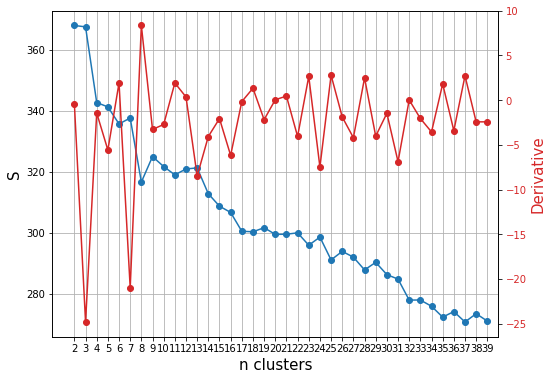

In [171]:
plot_elbow(feature_matrix_min001, max_clusters=40, ngram_range=(1,1), random_state = random_state)

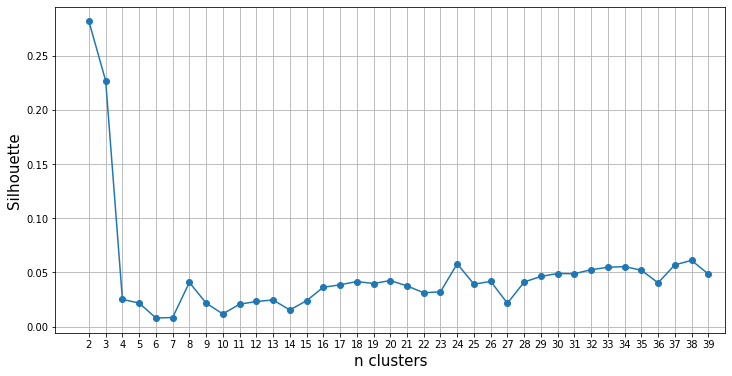

In [49]:
plot_silhouette_clusters(feature_matrix_min001, max_clusters=40, random_state = random_state)

In [50]:
cls_prod_min001 = KMeans(n_clusters=3, random_state=random_state)
cls_prod_min001.fit(feature_matrix_min001)

KMeans(n_clusters=3, random_state=1234)

In [51]:
cls_prod_min001.predict(feature_matrix_min001)

array([2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 0,
       2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 1, 1,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 0, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0,
       2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1,

In [52]:
silhouette_score(feature_matrix_min001, labels=cls_prod_min001.labels_)

0.2267114556367197

In [53]:
cls_prod_min001.inertia_

349.6031421055836

In [54]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_prod_min001 = pca.fit_transform(feature_matrix_min001.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_prod_min001 = pca.transform(cls_prod_min001.cluster_centers_)

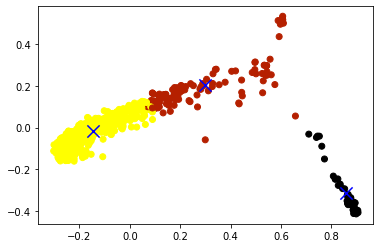

In [55]:
plt.scatter(reduced_features_prod_min001[:,0], reduced_features_prod_min001[:,1], c=cls_prod_min001.predict(feature_matrix_min001),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_prod_min001[:, 0], reduced_cluster_centers_prod_min001[:,1], marker='x', s=150, c='b')

## Affinity Propagation

*only min_df=0,1 converged*

In [178]:
af_prod = AffinityPropagation(random_state=random_state)
af_prod.fit(feature_matrix_min01)

AffinityPropagation(random_state=1234)

In [179]:
af_prod.labels_

array([ 95,   9,  38,  28,  55,  55, 101,  56,  81,  87,  91,  38,  56,
        96,   7,  26,   3,   0,  55,  87,   1,  56, 100,  95,   2,  42,
        87,   9,  63, 100,  19,  51,  51,  81,  40,   7,  39,  51,  51,
        75,  91,  87, 101,  39, 100,  95,   3,   4,  42, 101,  96, 101,
         7,  81,  51,  19,  39,   7,   5,  38,   9,  46,  83,  42,  37,
        46,  56,   6,  55,  51,  62,  39,   7,  75,  56,  46,  56,   8,
         9,  37,   9, 101, 101,  10,  11,  12,  87,  55,  88,   9,   9,
        13,  14,  37,  81,  53,   9,  46,  81,   7, 101,  75,  87,  51,
        38,  95,  55,  46,  15,  42,  46,  76,  39,  95,  83,  87,  51,
        81,  16,  38,   9,   7,  53,  17, 111,  83, 100,  18,  75,  19,
        20, 101,  21, 100,  51,  22,  95,  97,  23,  95,   9, 101,   9,
        79,  96,  24,  53,  55,  91,  55,  19,  25,  37,  55,  26,  42,
        27,  91,  56,  46,  95,  81,  50,  51,  51, 100,  46,  28,  42,
        56,  95,  46,  29,  46,  30,  76,  40, 100,   9,  55,  7

In [180]:
af_prod.cluster_centers_

<112x2898 sparse matrix of type '<class 'numpy.float64'>'
	with 65183 stored elements in Compressed Sparse Row format>

In [181]:
af_prod.n_iter_

66

In [182]:
silhouette_score(feature_matrix_min01, labels=af_prod.labels_)

0.11562503438686186

# Using Production data with no stopwords

## No stopwords, min_df=0, max_df=1

In [7]:
# loading feature matrix
with open('feature_matrix_prod_tfidf_ngram_1_1_min_df_0_max_df_1_no_stop_words.pkl','rb') as f:
    feature_matrix_no_stopwords = pickle.load(f) 

In [8]:
print("n_samples: %d, n_features: %d" % feature_matrix_no_stopwords.shape)

n_samples: 741, n_features: 135383


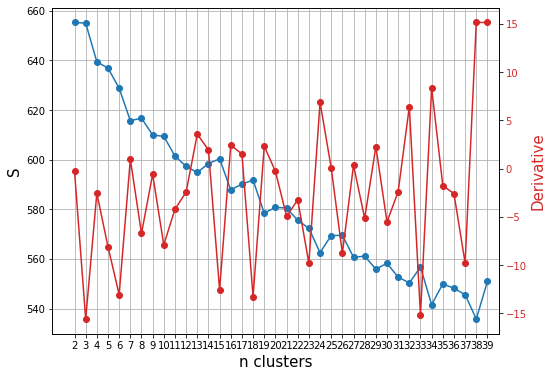

In [185]:
plot_elbow(feature_matrix_no_stopwords, max_clusters=40, ngram_range=(1,1), random_state = random_state)

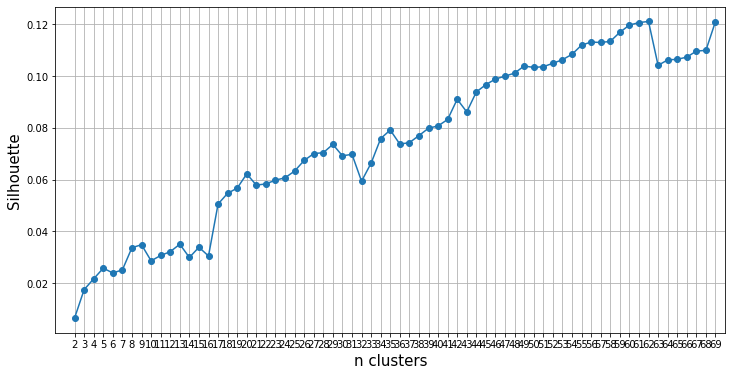

In [12]:
plot_silhouette_clusters(feature_matrix_no_stopwords, max_clusters=70, random_state = random_state)

In [9]:
cls_prod_no_stopwords = KMeans(n_clusters=62, random_state=random_state)
cls_prod_no_stopwords.fit(feature_matrix_no_stopwords)

KMeans(n_clusters=62, random_state=1234)

In [10]:
cls_prod_no_stopwords.predict(feature_matrix_no_stopwords)

array([27, 26,  1, 21, 27, 27,  3, 30, 27, 53, 52, 21, 42,  6, 49, 18, 27,
        0, 27, 49, 25, 42, 27, 27, 51,  9, 27, 27,  5, 56, 18, 27, 27, 27,
       25, 16, 23, 27, 27, 27, 52, 12, 21, 13,  5,  9, 27, 27,  9, 23, 38,
       13,  7, 28, 21, 18, 23,  7, 15, 21, 20,  1, 21, 55, 53,  1, 42, 27,
       21, 27, 10, 27, 24, 27, 42, 27, 30, 46, 27, 53, 56, 23, 23, 57, 45,
       19, 27, 27, 13, 22, 14, 17, 18, 53, 45, 27, 32,  1, 33, 34, 23,  8,
       21, 34, 56, 27,  8,  1, 54, 55,  1, 21, 27, 27, 21, 27, 56, 28, 27,
       21, 27, 24, 40, 27, 51, 21, 47, 15,  8, 18, 27, 23, 27,  7, 27, 17,
       56, 27, 27, 27, 27, 16, 58, 15,  6, 27, 40,  9, 21, 41, 18, 23, 45,
       27, 18, 55, 36, 52, 42,  1, 52, 34, 27, 27, 47, 39,  1, 21, 55, 30,
       27,  1, 51,  1, 45, 21, 25, 27, 27, 27, 33, 27, 27, 27, 27, 40,  7,
        7,  8, 21, 45, 29, 56, 19, 27, 19, 27,  5,  7, 31,  7, 30, 30, 27,
        8,  1, 47, 51,  9, 27, 57, 12, 56,  2, 21,  7, 54, 27, 21, 37, 38,
       27, 27, 27, 38,  8

In [11]:
silhouette_score(feature_matrix_no_stopwords, labels=cls_prod_no_stopwords.labels_)

0.12103720497064525

In [12]:
cls_prod_no_stopwords.inertia_

467.84060160111943

In [13]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_prod_no_stopwords = pca.fit_transform(feature_matrix_no_stopwords.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_prod_no_stopwords = pca.transform(cls_prod_no_stopwords.cluster_centers_)

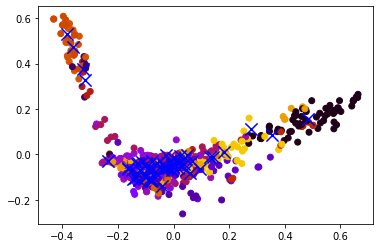

In [14]:
plt.scatter(reduced_features_prod_no_stopwords[:,0], reduced_features_prod_no_stopwords[:,1], c=cls_prod_no_stopwords.predict(feature_matrix_no_stopwords),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_prod_no_stopwords[:, 0], reduced_cluster_centers_prod_no_stopwords[:,1], marker='x', s=150, c='b')

In [34]:
af_prod_no_stopwords = AffinityPropagation(random_state=random_state)
af_prod_no_stopwords.fit(feature_matrix_no_stopwords)

/usr/local/lib64/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:244: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


AffinityPropagation(random_state=1234)

## No stopwords, min_df=0.01, max_df=0.9

In [15]:
# loading feature matrix
with open('feature_matrix_prod_tfidf_ngram_1_1_min_df_0p01_max_df_0p9_no_stop_words.pkl','rb') as f:
    feature_matrix_no_stopwords_v2 = pickle.load(f) 

In [16]:
print("n_samples: %d, n_features: %d" % feature_matrix_no_stopwords_v2.shape)

n_samples: 741, n_features: 12718


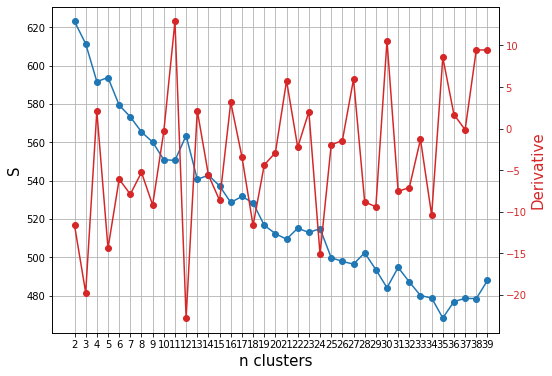

In [37]:
plot_elbow(feature_matrix_no_stopwords_v2, max_clusters=40, ngram_range=(1,1), random_state = random_state)

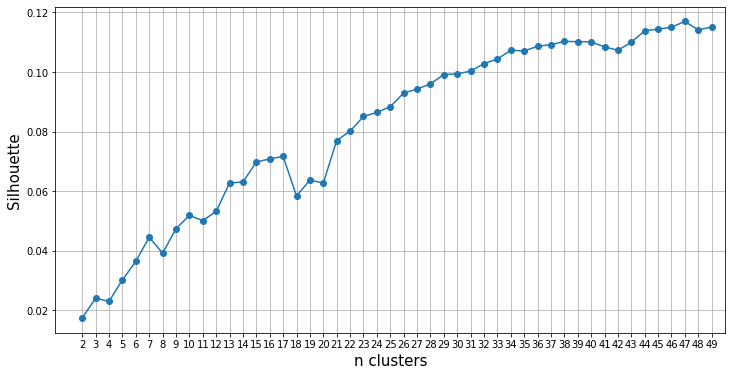

In [17]:
plot_silhouette_clusters(feature_matrix_no_stopwords_v2, max_clusters=50, random_state = random_state)

In [18]:
cls_prod_no_stopwords_v2 = KMeans(n_clusters=47, random_state=random_state)
cls_prod_no_stopwords_v2.fit(feature_matrix_no_stopwords_v2)

KMeans(n_clusters=47, random_state=1234)

In [19]:
cls_prod_no_stopwords_v2.predict(feature_matrix_no_stopwords_v2)

array([11, 42,  2, 11, 11, 17, 17, 10, 14, 22,  3,  2, 10, 15, 21, 19, 11,
        9, 42, 21,  1, 10,  0, 11,  9,  8, 11, 42,  7,  0, 19, 11, 11, 14,
        1, 28, 37,  0,  0, 16,  3,  2,  2, 18,  7, 12,  0, 23,  8, 34, 15,
       18, 17, 43, 11, 19, 37, 17, 23,  2, 42,  6, 12,  8, 22,  3, 10, 23,
        2, 11, 31, 34, 40, 11, 10,  3, 10, 14, 14, 22,  6, 34, 34, 46, 11,
       33, 42, 14, 18, 14, 27, 11, 19, 22, 11, 20, 25,  3,  4, 15, 37, 16,
        2, 17,  2, 17, 16,  3, 21, 23,  3, 39, 29, 14,  2, 14,  0, 43, 11,
        2, 11, 41, 13, 11, 44,  2, 11, 23, 16, 19, 11, 34, 11,  0, 11, 11,
        6, 11, 42, 17, 14, 28, 42, 23, 15, 36, 13, 12, 11, 42, 19, 26, 17,
       42, 19,  8, 28,  3, 10,  3, 11, 11, 23,  0, 11,  0,  3, 11,  8, 10,
       11,  3, 11,  3, 11, 39,  1, 14, 14, 14,  4, 11, 11, 42, 14, 13, 34,
       34, 16, 35, 32, 42,  6, 33, 23, 33, 14,  7, 30, 42, 41, 10, 10, 20,
       16,  3,  8, 44,  2, 11, 46,  2, 42,  0,  2, 34, 21, 42, 42,  8, 15,
       17, 14, 42, 15, 16

In [20]:
silhouette_score(feature_matrix_no_stopwords_v2, labels=cls_prod_no_stopwords_v2.labels_)

0.11695216608975098

In [21]:
cls_prod_no_stopwords_v2.inertia_

435.89602563041456

In [22]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_prod_no_stopwords_v2 = pca.fit_transform(feature_matrix_no_stopwords_v2.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_prod_no_stopwords_v2 = pca.transform(cls_prod_no_stopwords_v2.cluster_centers_)

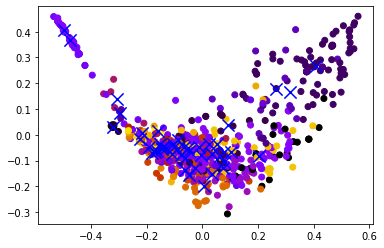

In [23]:
plt.scatter(reduced_features_prod_no_stopwords_v2[:,0], reduced_features_prod_no_stopwords_v2[:,1], c=cls_prod_no_stopwords_v2.predict(feature_matrix_no_stopwords_v2),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_prod_no_stopwords_v2[:, 0], reduced_cluster_centers_prod_no_stopwords_v2[:,1], marker='x', s=150, c='b')

In [50]:
af_prod_no_stopwords_v2 = AffinityPropagation(random_state=random_state)
af_prod_no_stopwords_v2.fit(feature_matrix_no_stopwords_v2)

/usr/local/lib64/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:244: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


AffinityPropagation(random_state=1234)

## No stopwords, min_df=0.05, max_df=0.9

In [24]:
# loading feature matrix
with open('feature_matrix_prod_tfidf_ngram_1_1_min_df_0p05_max_df_0p9_no_stop_words.pkl','rb') as f:
    feature_matrix_no_stopwords_v3 = pickle.load(f) 

In [25]:
print("n_samples: %d, n_features: %d" % feature_matrix_no_stopwords_v3.shape)

n_samples: 741, n_features: 4286


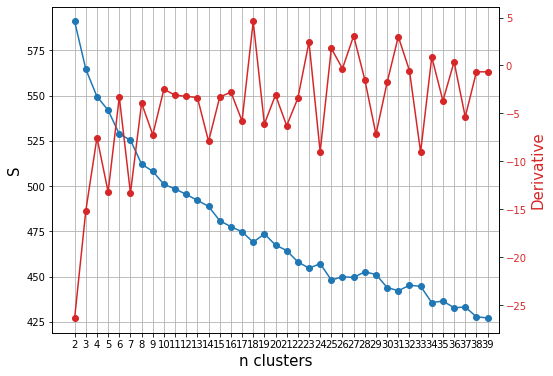

In [53]:
plot_elbow(feature_matrix_no_stopwords_v3, max_clusters=40, ngram_range=(1,1), random_state = 1234)

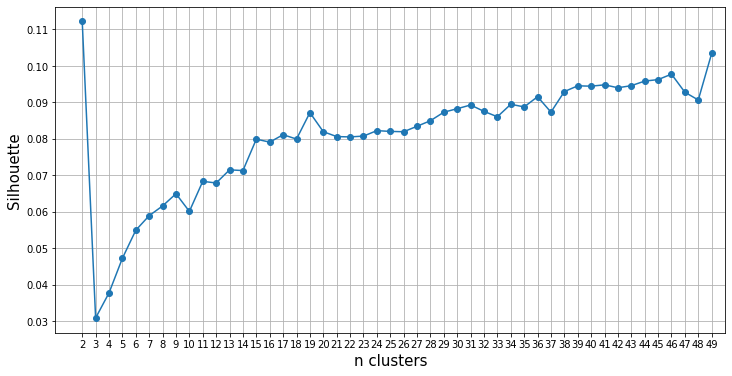

In [26]:
plot_silhouette_clusters(feature_matrix_no_stopwords_v3, max_clusters=50, random_state = random_state)

In [27]:
cls_prod_no_stopwords_v3 = KMeans(n_clusters=46, random_state=random_state)
cls_prod_no_stopwords_v3.fit(feature_matrix_no_stopwords_v3)

KMeans(n_clusters=46, random_state=1234)

In [28]:
cls_prod_no_stopwords_v3.predict(feature_matrix_no_stopwords_v3)

array([44, 38, 41,  2,  2, 18,  9,  6, 18, 45, 10, 26,  6, 30, 13, 38, 19,
       16, 18, 13, 15,  6, 22, 44, 16, 25,  8,  5, 35, 22, 38, 12, 40,  5,
       15, 43,  9, 22, 40, 18, 10,  8, 41,  2, 22, 43, 22, 38, 25,  9, 30,
        9,  9, 44,  2, 38,  9,  9,  2, 41, 13,  4, 13, 25, 11,  5,  6, 38,
        2, 40,  8,  9, 17, 18,  6,  5,  6, 18, 11, 11, 12,  9,  9, 33,  0,
       20, 45, 18,  9, 14, 14, 22, 38, 11, 14,  3, 11, 24,  7, 17,  9,  1,
        8, 18, 13, 44,  1,  5, 29, 19, 24,  2, 18, 43, 41, 18, 40, 44,  2,
       41, 38, 17,  3,  5, 21, 41, 19,  2, 16, 38,  2,  9,  1, 22, 44,  2,
        5, 37, 35, 11, 18,  9, 45, 27, 30, 38,  3, 13, 12, 45, 38, 32, 11,
       18, 38, 25, 44, 10,  6, 24, 10,  2,  2, 22, 12, 22,  5,  2, 25,  6,
       44, 24, 21,  5, 16, 16, 15, 18, 18, 36,  7,  2, 45, 35, 12,  3,  9,
        9, 16, 41, 31, 45, 12, 20,  2, 20, 44, 35,  9, 12,  9,  6,  6, 39,
       16, 24, 25, 21, 13,  2,  9,  8, 45, 22, 26,  9, 29,  2, 13, 25, 30,
       18, 43, 45, 30,  1

In [29]:
silhouette_score(feature_matrix_no_stopwords_v3, labels=cls_prod_no_stopwords_v3.labels_)

0.09775432244034579

In [30]:
cls_prod_no_stopwords_v3.inertia_

399.17498595250737

In [31]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_prod_no_stopwords_v3 = pca.fit_transform(feature_matrix_no_stopwords_v3.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_prod_no_stopwords_v3 = pca.transform(cls_prod_no_stopwords_v3.cluster_centers_)

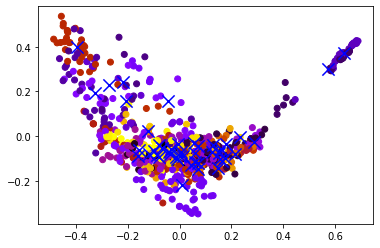

In [32]:
plt.scatter(reduced_features_prod_no_stopwords_v3[:,0], reduced_features_prod_no_stopwords_v3[:,1], c=cls_prod_no_stopwords_v3.predict(feature_matrix_no_stopwords_v3),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_prod_no_stopwords_v3[:, 0], reduced_cluster_centers_prod_no_stopwords_v3[:,1], marker='x', s=150, c='b')

In [85]:
af_prod_no_stopwords_v3 = AffinityPropagation(random_state=random_state)
af_prod_no_stopwords_v3.fit(feature_matrix_no_stopwords_v3)

/usr/local/lib64/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:244: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


AffinityPropagation(random_state=1234)

## No stopwords, ngram=(1,2), min_df=0, max_df=1

In [7]:
# loading feature matrix
with open('feature_matrix_prod_tfidf_ngram_1_2_min_df_0_max_df_1_no_stop_words.pkl','rb') as f:
    feature_matrix_no_stopwords_v4 = pickle.load(f) 

In [8]:
print("n_samples: %d, n_features: %d" % feature_matrix_no_stopwords_v4.shape)

n_samples: 741, n_features: 1516451


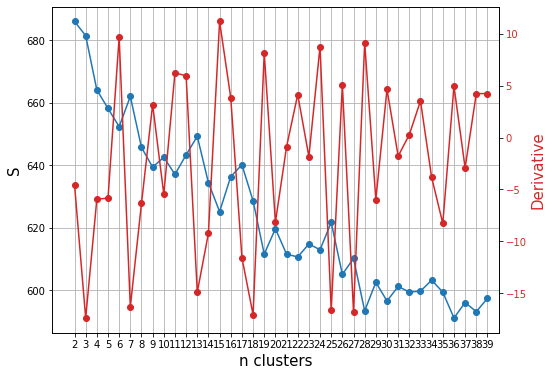

In [88]:
plot_elbow(feature_matrix_no_stopwords_v4, max_clusters=40, ngram_range=(1,2), random_state = random_state)

In [ ]:
plot_silhouette_clusters(feature_matrix_no_stopwords_v4, max_clusters=40, random_state = random_state)

In [8]:
cls_prod_no_stopwords_v4 = KMeans(n_clusters=36, random_state=random_state)
cls_prod_no_stopwords_v4.fit(feature_matrix_no_stopwords_v4)

KMeans(n_clusters=36, random_state=1234)

In [9]:
cls_prod_no_stopwords_v4.predict(feature_matrix_no_stopwords_v4)

array([33, 19, 27, 33, 33, 33,  9, 22,  0,  3, 27,  9, 22, 15, 21, 17, 33,
       20, 33, 21, 16, 22, 33, 33,  2, 31, 33, 33, 35, 33, 17, 33, 33, 33,
       16, 23,  9, 33, 33, 20, 27, 33, 33, 30, 35, 33, 33, 33, 31,  9, 15,
       30, 12,  0, 33, 17,  9,  9, 33, 33, 14,  7, 33, 31,  3,  7, 22, 33,
       33, 33, 25, 23,  0, 33, 22,  7, 22, 35, 33,  3,  0,  9,  9, 33, 35,
       11, 33, 33, 30, 33, 35, 33, 17,  3, 33,  5, 25,  7, 32,  0,  9, 20,
       19, 35,  6, 33,  0,  7, 33, 29,  7, 33, 33,  0, 28, 33,  7,  0, 33,
       33, 33,  0,  8, 33, 33, 33, 33, 33, 20, 17, 33,  9, 33, 12, 33, 33,
        0, 33, 24, 33, 33, 23, 33, 11, 15, 33,  8,  6, 33, 33, 17,  9, 33,
       33, 17, 31, 23, 27, 22,  7, 33, 33, 33,  1, 33, 33,  7, 33, 31, 22,
       33,  7, 33,  7, 31, 33, 16, 33, 33, 35, 32, 33, 33, 33, 33,  8,  9,
       12, 20, 33, 33, 33, 33, 11, 31, 11,  0, 35, 28, 33,  9, 22, 22,  5,
       20,  7, 31, 26, 27, 33, 33, 33,  6,  0, 10,  9, 12, 31, 33, 31, 15,
       33,  0,  6, 15,  0

In [10]:
silhouette_score(feature_matrix_no_stopwords_v4, labels=cls_prod_no_stopwords_v4.labels_)

0.057089230674613294

In [11]:
cls_prod_no_stopwords_v4.inertia_

567.9322763243746

In [12]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_prod_no_stopwords_v4 = pca.fit_transform(feature_matrix_no_stopwords_v4.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_prod_no_stopwords_v4 = pca.transform(cls_prod_no_stopwords_v4.cluster_centers_)

MemoryError: Unable to allocate 8.37 GiB for an array with shape (741, 1516451) and data type float64

In [ ]:
plt.scatter(reduced_features_prod_no_stopwords_v4[:,0], reduced_features_prod_no_stopwords_v4[:,1], c=cls_prod_no_stopwords_v4.predict(feature_matrix_no_stopwords_v4),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_prod_no_stopwords_v4[:, 0], reduced_cluster_centers_prod_no_stopwords_v4[:,1], marker='x', s=150, c='b')

**Affinity Propagation**

In [97]:
af_prod_no_stopwords_v4 = AffinityPropagation(random_state=random_state)
af_prod_no_stopwords_v4.fit(feature_matrix_no_stopwords_v4)

AffinityPropagation(random_state=1234)

In [98]:
af_prod_no_stopwords_v4.labels_

array([ 0,  0,  0,  0,  0,  0,  0, 12,  0,  7, 42,  0, 33,  0,  0,  0,  0,
        0,  0,  0, 19, 33,  0,  0,  0,  0,  0,  0, 35,  0,  0,  0,  0,  0,
       19,  0,  0,  0,  0,  0, 42,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 11,  0,  0,  9,  0,  0,  0,  2,  0,  0,  0,  7, 25,  0,  0,
        0,  0,  0,  0,  0,  0, 33,  3, 12,  0,  0,  7,  0,  0,  0,  0,  4,
        5,  0,  0, 41,  0,  6,  0,  0,  7,  0, 40,  8,  0,  0,  0,  9,  0,
        0, 10,  0,  0,  0,  0,  0,  0, 25,  0,  0,  0,  0,  0,  0, 11,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 44,  0,  0,  0,  0, 28, 37,  0,  0, 34,  0,  0, 21,  0,  0,  0,
        0,  0,  0,  0, 42, 33, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,
        0,  0,  0,  0,  0,  0, 19,  0,  0, 17, 20,  0,  0,  0,  0, 34,  0,
        0,  0,  0,  0,  0,  0,  5,  0,  5,  0, 36,  0,  0,  0,  0,  0,  0,
        0, 25,  0,  0,  0,  0,  0,  0,  0, 13,  0,  0, 14,  0,  0, 15,  0,
        0,  0,  0,  0,  0

In [99]:
af_prod_no_stopwords_v4.cluster_centers_

<49x1516451 sparse matrix of type '<class 'numpy.float64'>'
	with 351998 stored elements in Compressed Sparse Row format>

In [100]:
af_prod_no_stopwords_v4.n_iter_

196

In [101]:
silhouette_score(feature_matrix_no_stopwords_v4, labels=af_prod_no_stopwords_v4.labels_)

0.10615945869028132

## No stopwords, ngram=(1,2), min_df=0.5, max_df=0.9

In [13]:
# loading feature matrix
with open('feature_matrix_prod_tfidf_ngram_1_2_min_df_0p5_max_df_0p9_no_stop_words.pkl','rb') as f:
    feature_matrix_no_stopwords_v5 = pickle.load(f) 

In [14]:
print("n_samples: %d, n_features: %d" % feature_matrix_no_stopwords_v5.shape)

n_samples: 741, n_features: 9703


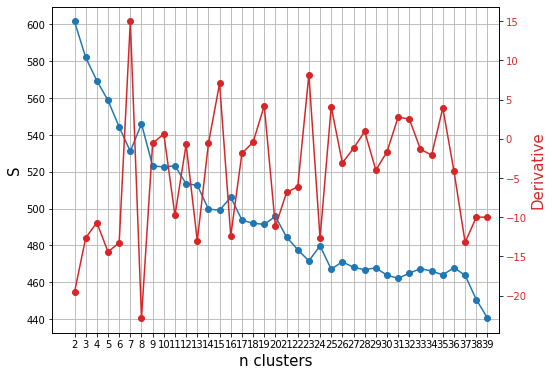

In [104]:
plot_elbow(feature_matrix_no_stopwords_v5, max_clusters=40, ngram_range=(1,2), random_state = random_state)

In [ ]:
plot_silhouette_clusters(feature_matrix_no_stopwords_v5, max_clusters=40, random_state = random_state)

In [18]:
cls_prod_no_stopwords_v5 = KMeans(n_clusters=39, random_state=random_state)
cls_prod_no_stopwords_v5.fit(feature_matrix_no_stopwords_v5)

KMeans(n_clusters=39, random_state=1234)

In [19]:
cls_prod_no_stopwords_v5.predict(feature_matrix_no_stopwords_v5)

array([ 3, 12, 10, 13, 13,  1, 35,  2,  3,  1, 14, 10,  2, 22, 28,  7, 21,
       16,  1,  7, 23,  2, 15, 13, 29, 10, 19,  8, 24, 15, 12, 26, 21,  8,
       23, 20, 35, 15, 26, 16, 14, 19, 10, 35, 15,  3, 15, 36, 10, 35, 22,
       35, 12,  3, 13, 12,  5, 12,  7, 10, 24, 27, 10, 32, 18,  8,  2,  7,
        7, 26,  7,  9, 20, 13,  2,  8,  2, 30, 11, 18, 20, 35, 35,  6, 18,
       17,  7,  1, 35, 11, 11, 26,  7, 18, 11, 38, 33,  8, 25, 20, 35, 16,
       19, 30,  7, 26, 16,  8, 28,  7,  8, 13, 12,  3, 10, 33, 26,  3, 13,
       10,  9, 27,  4, 20, 29, 10, 13,  7, 16, 11,  7, 35, 13, 12,  1, 13,
       20,  1, 24, 11,  3,  9, 24,  7, 15, 17,  4, 31, 27,  1, 11, 13, 18,
        1,  7, 32, 13, 14,  2,  8,  3,  7,  7, 15, 13, 15,  8, 13, 32,  2,
       26,  8, 29,  8, 32, 16, 23,  1,  7, 12, 25, 13, 34, 24,  1,  4,  5,
        5, 16, 13, 13,  7, 13, 17, 13, 17,  3, 19, 35,  8,  5,  2,  2, 38,
       16,  8, 32, 29, 10, 13,  5, 19,  7, 15, 10,  5, 28,  9,  1, 32, 22,
       12,  3,  7, 22, 16

In [20]:
silhouette_score(feature_matrix_no_stopwords_v5, labels=cls_prod_no_stopwords_v5.labels_)

0.09354441374781418

In [21]:
cls_prod_no_stopwords_v5.inertia_

425.47267281514854

In [22]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_prod_no_stopwords_v5 = pca.fit_transform(feature_matrix_no_stopwords_v5.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_prod_no_stopwords_v5 = pca.transform(cls_prod_no_stopwords_v5.cluster_centers_)

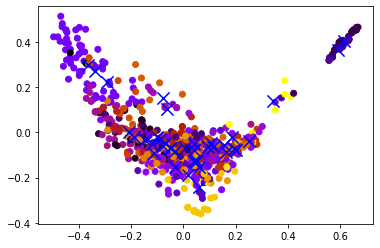

In [23]:
plt.scatter(reduced_features_prod_no_stopwords_v5[:,0], reduced_features_prod_no_stopwords_v5[:,1], c=cls_prod_no_stopwords_v5.predict(feature_matrix_no_stopwords_v5),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_prod_no_stopwords_v5[:, 0], reduced_cluster_centers_prod_no_stopwords_v5[:,1], marker='x', s=150, c='b')

In [117]:
af_prod_no_stopwords_v5 = AffinityPropagation(random_state=random_state)
af_prod_no_stopwords_v5.fit(feature_matrix_no_stopwords_v5)

/usr/local/lib64/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:244: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


AffinityPropagation(random_state=1234)

# Production Data - Doc2Vec

In [8]:
with open('sentences.pkl','rb') as f:
    sentences = pickle.load(f) 

In [9]:
len(sentences)

719686

In [10]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(sentences)]

In [12]:
max_epochs = 100
vec_size = 300
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v_prod.model")
print("Model Saved")

/usr/local/lib64/python3.6/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [10]:
model= Doc2Vec.load("d2v_prod.model")

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

[('27185', 0.93514084815979), ('141556', 0.7975534200668335), ('141402', 0.7944866418838501), ('141401', 0.794184684753418), ('141634', 0.7941325902938843), ('345929', 0.7931180000305176), ('344453', 0.7925615310668945), ('141558', 0.7912154197692871), ('141560', 0.7911758422851562), ('141400', 0.7900334596633911)]
[-5.11201560e-01 -2.60394901e-01 -1.17955670e-01 -2.48055056e-01
 -1.38579383e-01  5.89157864e-02 -1.15839988e-01 -1.17500171e-01
 -1.17359787e-01 -1.78677961e-01  7.59587139e-02 -1.75578073e-01
 -9.22169983e-01 -1.71102464e-01 -1.42228633e-01 -7.79609680e-02
  5.36040246e-01 -3.33206832e-01 -1.17234495e-02 -5.85852489e-02
 -1.41112432e-01 -3.70078146e-01 -1.18213065e-01 -8.00002888e-02
  8.56589340e-03 -2.75316089e-01 -1.03819914e-01 -1.30727187e-01
 -2.10976958e-01  3.49887669e-01  1.63009733e-01  2.13598922e-01
  4.99544293e-01 -4.09790017e-02 -3.69819373e-01  1.78422645e-01
 -2.37293504e-02  6.00575097e-03 -7.40946755e-02  4.67065603e-01
 -2.34539285e-02 -4.35043484e-01 

In [11]:
type(model)

gensim.models.doc2vec.Doc2Vec

cluster number 2
inertia 56453729.141693115
cluster number 3
inertia 55334490.40270996
cluster number 4
inertia 56381651.03790283
cluster number 5
inertia 56088369.21569824
cluster number 6
inertia 55043025.73460388
cluster number 7
inertia 55169554.90156555
cluster number 8
inertia 55118674.28071594
cluster number 9
inertia 55212824.656448364
cluster number 10
inertia 55090572.16511536
cluster number 11
inertia 55149665.2277832
cluster number 12
inertia 55042314.728393555
cluster number 13
inertia 54885757.28242493
cluster number 14
inertia 54724671.577926636
cluster number 15
inertia 55741171.483810425
cluster number 16
inertia 54883712.9672699
cluster number 17
inertia 55133167.6318512
cluster number 18
inertia 54754021.31187439
cluster number 19
inertia 55082176.34703064
cluster number 20
inertia 55093976.6078186
cluster number 21
inertia 52207027.39424133
cluster number 22
inertia 51932722.417022705
cluster number 23
inertia 51423162.69139862
cluster number 24
inertia 52551327.108

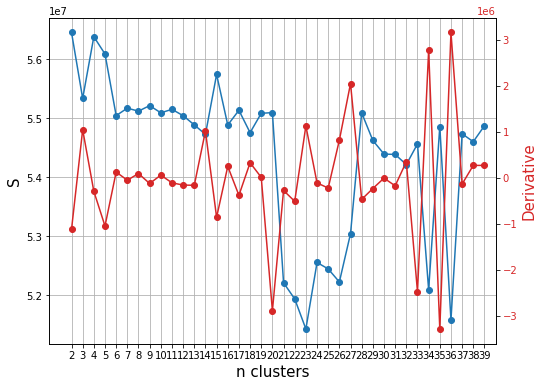

In [10]:
plot_elbow(model.docvecs.vectors_docs, max_clusters=40, ngram_range=(1,1), random_state = random_state)

In [ ]:
plot_silhouette_clusters(model.docvecs.vectors_docs, max_clusters=25, random_state = random_state)

cluster number 2
silhouette score 0.2643369734287262
cluster number 3
silhouette score 0.20821110904216766
cluster number 4


In [12]:
cls_prod_doc2vec = KMeans(n_clusters=23, random_state=random_state)
cls_prod_doc2vec.fit(model.docvecs.vectors_docs)
pickle.dump(cls_prod_doc2vec,open("cls_prod_doc2vec.pkl","wb"))

In [6]:
with open('cls_prod_doc2vec.pkl','rb') as f:
    cls_prod_doc2vec = pickle.load(f) 

In [13]:
cls_prod_doc2vec_predict = cls_prod_doc2vec.predict(model.docvecs.vectors_docs)
pickle.dump(cls_prod_doc2vec,open("cls_prod_doc2vec_predict.pkl","wb"))

In [7]:
with open('cls_prod_doc2vec_predict.pkl','rb') as f:
    cls_prod_doc2vec_predict = pickle.load(f) 

In [13]:
silhouette_score(model.docvecs.vectors_docs, labels=cls_prod_doc2vec.labels_)

0.012168544

In [8]:
cls_prod_doc2vec.inertia_

51296288.0

In [12]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features_prod_doc2vec = pca.fit_transform(model.docvecs.vectors_docs)

# reduce the cluster centers to 2D
reduced_cluster_centers_prod_doc2vec = pca.transform(cls_prod_doc2vec.cluster_centers_)

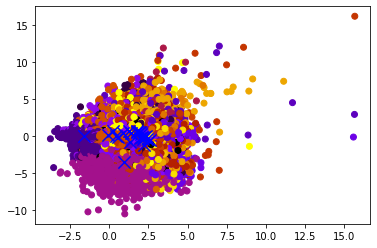

In [14]:
plt.scatter(reduced_features_prod_doc2vec[:,0], reduced_features_prod_doc2vec[:,1], c=cls_prod_doc2vec.predict(model.docvecs.vectors_docs),cmap=plt.get_cmap('gnuplot'))
plt.scatter(reduced_cluster_centers_prod_doc2vec[:, 0], reduced_cluster_centers_prod_doc2vec[:,1], marker='x', s=150, c='b')